In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("Ranodm_Forest").getOrCreate()
data = pd.read_csv("diabetes_prediction_dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
data = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)

target_col = "diabetes"
data = data.drop("gender")
data = data.drop("smoking_history")
feature_cols = [col for col in data.columns if col != target_col]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = vector_assembler.transform(data)

In [53]:
(train, test) = data.randomSplit([0.7, 0.3], seed = 1)
print(test)
print(feature_cols)


DataFrame[age: double, hypertension: int, heart_disease: int, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int, features: vector]
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [54]:
rf = RandomForestClassifier(labelCol=target_col, featuresCol="features")
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="accuracy"
)

In [57]:
s=[]
for i in range(1,10):
    
    train1, test1 = data.randomSplit([i/10, 1-(i/10)], seed=123)

    rf1 = RandomForestClassifier(labelCol=target_col, featuresCol="features")
    rfModel1 = rf1.fit(train1)
    predictions1 = rfModel1.transform(test1)

    evaluator1 = MulticlassClassificationEvaluator(
        labelCol=target_col, predictionCol="prediction", metricName="accuracy"
    )
    accuracy1 = evaluator1.evaluate(predictions1)
    s.append(accuracy1)

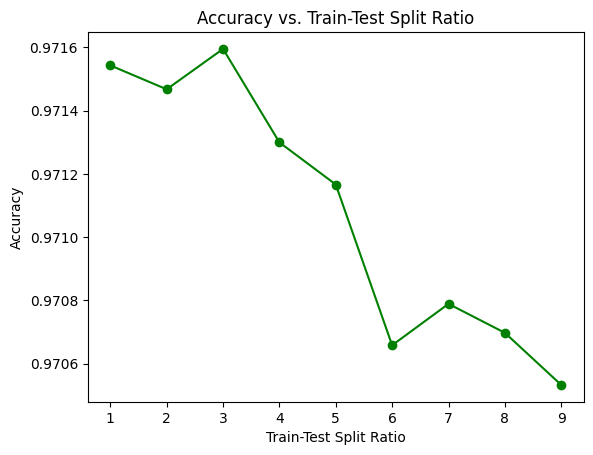

In [63]:
plt.plot(range(1, 10), s, marker='o',color = 'green')
plt.title('Accuracy vs. Train-Test Split Ratio')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.show()

In [59]:
accuracy = evaluator.evaluate(predictions)
tp = predictions.filter("diabetes = 1 AND prediction = 1").count()
fp = predictions.filter("diabetes = 0 AND prediction = 1").count()
tn = predictions.filter("diabetes = 0 AND prediction = 0").count()
fn = predictions.filter("diabetes = 1 AND prediction = 0").count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9728948679621325
Precision: 1.0
Recall: 0.6844547563805105
F1 Score: 0.81267217630854


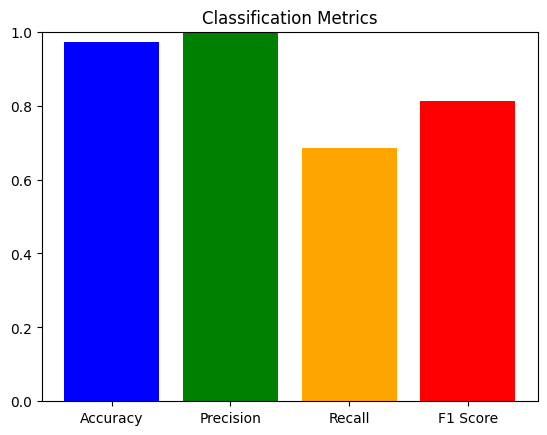

In [64]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.show()

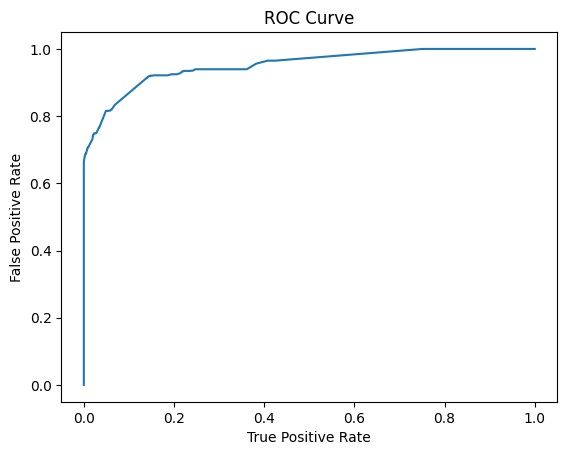

TrainSet areaUnderROC: 0.9517336471270319


In [60]:
trainSet = rfModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

In [61]:
prediction_and_label = predictions.select("prediction", target_col).rdd.map(lambda row: (float(row.prediction), float(row[target_col])))

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

C:\Users\blruc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[27519.     0.]
 [  816.  1770.]]


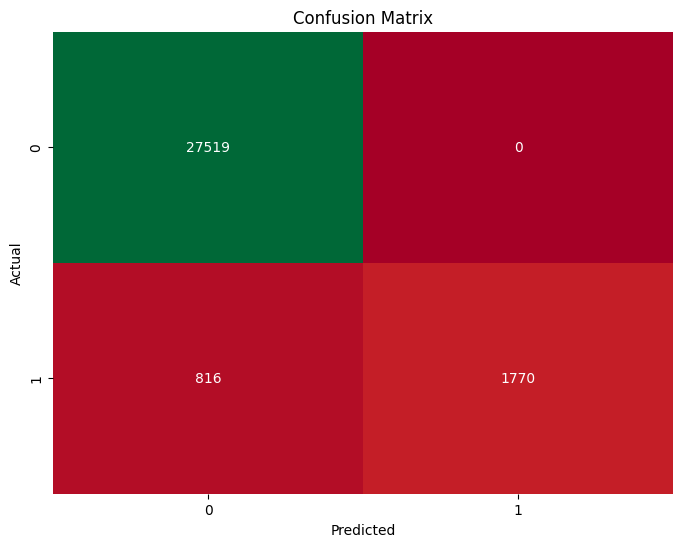

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap=sns.color_palette("RdYlGn", as_cmap=True), cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
predictions = rfModel.transform(test)
predictions.show(10)


+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|       rawPrediction|         probability|prediction|
+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
|0.08|           0|            0| 12.1|        6.1|                159|       0|[0.08,0.0,0.0,12....|[19.6415037616026...|[0.98207518808013...|       0.0|
|0.08|           0|            0|12.22|        3.5|                130|       0|[0.08,0.0,0.0,12....|[19.6971091669648...|[0.98485545834824...|       0.0|
|0.08|           0|            0|13.03|        6.2|                158|       0|[0.08,0.0,0.0,13....|[19.6415037616026...|[0.98207518808013...|       0.0|
|0.08|           0|            0|13.35|        3.5|                145

In [46]:
spark.stop()